In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

#Import textfiles
gainFile = "Gain_Zenith_PVA.txt"
phaseFile = "Phase_Zenith_PVA.txt"
unwrappedPhaseFile = "Unwrapped_Phase_Zenith_PVA.txt"
crossPolGainFile = "Gain_Zenith_PVA_Cross.txt"
crossPolPhaseFile = "Phase_Zenith_PVA.txt"  #Using co-pol phase as a placeholder until I get the data from Mohammad.
swrReflectionFile = "PVA_VSWR_Reflection_Coefficient.txt"
impedanceFile = "pva_s11_complex_impedance.txt"
araImpedanceFile = "ara_antennas_complex_impedance.txt"

gainData = np.genfromtxt(gainFile,skip_header=1, dtype=None, delimiter=',')
phaseData = np.genfromtxt(phaseFile,skip_header=1, dtype=None, delimiter=',')
unwrappedPhaseData = np.genfromtxt(unwrappedPhaseFile,skip_header=1, dtype=None, delimiter=',')
crossPolGainData = np.genfromtxt(crossPolGainFile,skip_header=1, dtype=None, delimiter=',')
crossPolPhaseData = np.genfromtxt(crossPolPhaseFile,skip_header=1, dtype=None, delimiter=',')
swrReflectionData = np.genfromtxt(swrReflectionFile,skip_header=1, dtype=None, delimiter=',')
impedanceData = np.genfromtxt(impedanceFile,skip_header=1, dtype=complex, delimiter=',')
araImpedanceData = np.genfromtxt(araImpedanceFile,skip_header=1, dtype=complex, delimiter=',')

#Import Mohammad's updated realized gain files
pvaRealizedGainPhaseCopolFile = "Gain_Phase_PVA_Co.txt"
pvaRealizedGainPhaseCrosspolFile = "Gain_Phase_PVA_Cross.txt"
araVpolRealizedGainPhaseCopolFile = "Gain_Phase_ARAVPol_Co.txt"
araVpolRealizedGainPhaseCrosspolFile = "Gain_Phase_ARAVPol_Cross.txt"
araHpolRealizedGainPhaseCopolFile = "Gain_Phase_ARAHPol_Co.txt"
araHpolRealizedGainPhaseCrosspolFile = "Gain_Phase_ARAHPol_Cross.txt"

pvaRealizedGainPhaseCopolData = np.genfromtxt(pvaRealizedGainPhaseCopolFile,skip_header=1, delimiter=',')
pvaRealizedGainPhaseCrosspolData = np.genfromtxt(pvaRealizedGainPhaseCrosspolFile,skip_header=1, delimiter=',')
araVpolRealizedGainPhaseCopolData = np.genfromtxt(araVpolRealizedGainPhaseCopolFile,skip_header=1, delimiter=',')
araVpolRealizedGainPhaseCrosspolData = np.genfromtxt(araVpolRealizedGainPhaseCrosspolFile,skip_header=1, delimiter=',')
araHpolRealizedGainPhaseCopolData = np.genfromtxt(araHpolRealizedGainPhaseCopolFile,skip_header=1, delimiter=',')
araHpolRealizedGainPhaseCrosspolData = np.genfromtxt(araHpolRealizedGainPhaseCrosspolFile,skip_header=1, delimiter=',')


In [2]:
#Create initial arrays for frequency, zenith, and azimuth (which we have symmetry, but it's good to write anyways)
inputZenith = gainData[:,0] #Mohammad's data goes from zero to 360 since he rotated the whole antenna on a table.
inputAzimuth = np.arange(0,361) #We have azimuthal symmetry in the PVA and ARA antennas, but we keep this format due to how XF outputs things and if we want to simulate non-azimuthally symmetric antennas.
inputFreq = np.arange(50,1050,50) #Mohammad measured every 50 MHz, which I'll need to interpolate to what we have in the AraSim data for antennas.

#Truncate first column form gain and phase data as it contains the zenith angles
gain = gainData[:,1:]
phase = phaseData[:,1:]
unwrappedPhase = unwrappedPhaseData[:,1:]
crossPolGain = crossPolGainData[:,1:]
crossPolPhase = crossPolPhaseData[:,1:]

#SWR file is structured in a slightly different fashion at more frequency intervals.  We'll import it on its own and then reinterpolate.
inputFreqSWR = swrReflectionData[:,0]
swr = swrReflectionData[:,1]
reflectionCoefficient = swrReflectionData[:,2]

#Impedance file is also at slightly different frequency intervals and has complex terms, so we'll import those separately as well
inputFreqImpedance = impedanceData[:,0].real
s11 = impedanceData[:,1]
impedance = impedanceData[:,2]

#Import the ARA Antenna impedance file data.
inputFreqAraImpedance = araImpedanceData[:,0].real
Z_TVpol = araImpedanceData[:,1]
Z_BVpol = araImpedanceData[:,2]
Z_Hpol = araImpedanceData[:,3]

#Initialize arrays for the realized gain data Mohammad took
inputZenithRealized = pvaRealizedGainPhaseCopolData[:,0]
inputAzimuthRealized = inputAzimuth #Azimuth and freq are the same from previous measurements Mohammad made.
inputFreqRealized = inputFreq

#Mohammad put gain and phase in the same file, which I'll need to separate.
pvaRealizedGainCopol = pvaRealizedGainPhaseCopolData[:,1:21]
pvaRealizedPhaseCopol = pvaRealizedGainPhaseCopolData[:,21:]
pvaRealizedGainCrosspol = pvaRealizedGainPhaseCrosspolData[:,1:21]
pvaRealizedPhaseCrosspol = pvaRealizedGainPhaseCrosspolData[:,21:]

araVpolRealizedGainCopol = araVpolRealizedGainPhaseCopolData[:,1:21]
araVpolRealizedPhaseCopol = araVpolRealizedGainPhaseCopolData[:,21:]
araVpolRealizedGainCrosspol = araVpolRealizedGainPhaseCrosspolData[:,1:21]
araVpolRealizedPhaseCrosspol = araVpolRealizedGainPhaseCrosspolData[:,21:]

araHpolRealizedGainCopol = araHpolRealizedGainPhaseCopolData[:,1:21]
araHpolRealizedPhaseCopol = araHpolRealizedGainPhaseCopolData[:,21:]
araHpolRealizedGainCrosspol = araHpolRealizedGainPhaseCrosspolData[:,1:21]
araHpolRealizedPhaseCrosspol = araHpolRealizedGainPhaseCrosspolData[:,21:]

Text(0, 0.5, 'Gain [dB]')

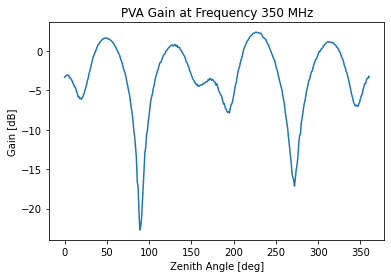

In [3]:
index = 6
plt.plot(inputZenith, gain[:,index])
plt.title("PVA Gain at Frequency " + str(inputFreq[index]) + " MHz")
plt.xlabel("Zenith Angle [deg]")
plt.ylabel("Gain [dB]")

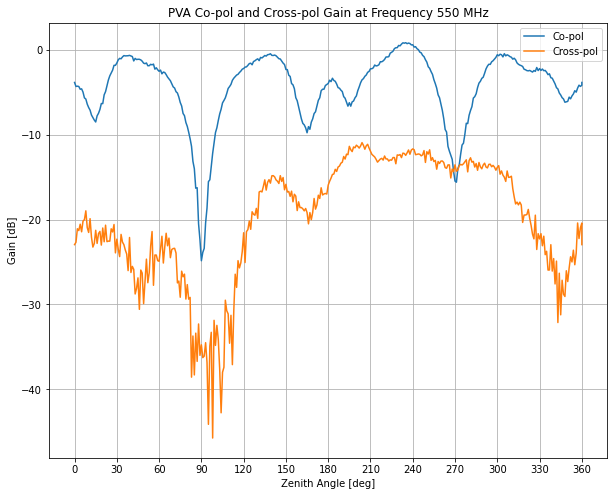

In [4]:
index = 10
fig = plt.figure(figsize=(10,8))
plt.plot(inputZenith, gain[:,index], label="Co-pol")
plt.plot(inputZenith, crossPolGain[:,index], label="Cross-pol")
plt.title("PVA Co-pol and Cross-pol Gain at Frequency " + str(inputFreq[index]) + " MHz")
plt.xlabel("Zenith Angle [deg]")
plt.ylabel("Gain [dB]")
plt.xticks(np.arange(0,390,30))
plt.grid()
plt.legend()

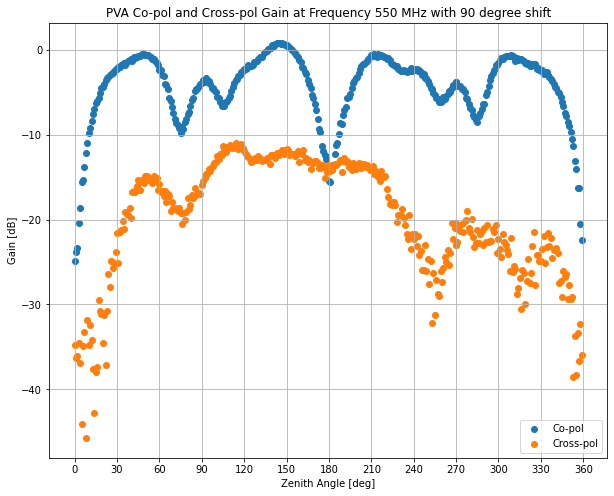

In [5]:
index = 10
fig = plt.figure(figsize=(10,8))
plt.scatter((inputZenith-90)%360, gain[:,index], label="Co-pol")
plt.scatter((inputZenith-90)%360, crossPolGain[:,index], label="Cross-pol")
plt.title("PVA Co-pol and Cross-pol Gain at Frequency " + str(inputFreq[index]) + " MHz with 90 degree shift")
plt.xlabel("Zenith Angle [deg]")
plt.ylabel("Gain [dB]")
plt.xticks(np.arange(0,390,30))
plt.grid()
plt.legend()

Text(0, 0.5, 'Gain [db]')

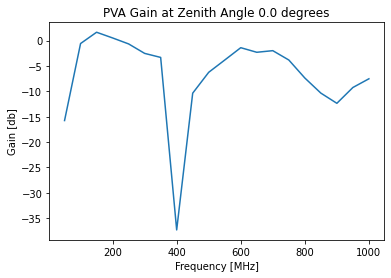

In [6]:
index = 0
plt.plot(inputFreq, gain[index,:])
plt.title("PVA Gain at Zenith Angle " + str(inputZenith[index]) + " degrees")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Gain [db]")

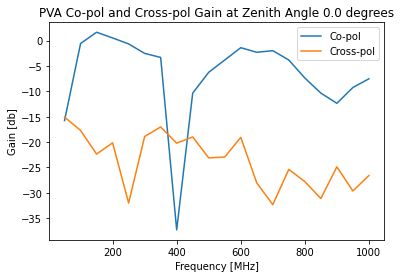

In [7]:
index = 0
plt.plot(inputFreq, gain[index,:], label="Co-pol")
plt.plot(inputFreq, crossPolGain[index,:], label="Cross-pol")
plt.title("PVA Co-pol and Cross-pol Gain at Zenith Angle " + str(inputZenith[index]) + " degrees")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Gain [db]")
plt.legend()

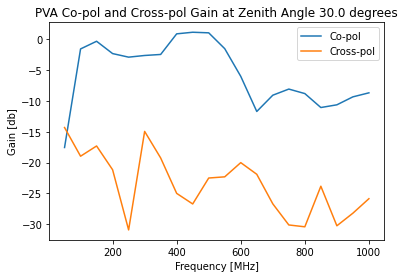

In [8]:
index = 30
plt.plot(inputFreq, gain[index,:], label="Co-pol")
plt.plot(inputFreq, crossPolGain[index,:], label="Cross-pol")
plt.title("PVA Co-pol and Cross-pol Gain at Zenith Angle " + str(inputZenith[index]) + " degrees")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Gain [db]")
plt.legend()

Text(0, 0.5, 'SWR [arb]')

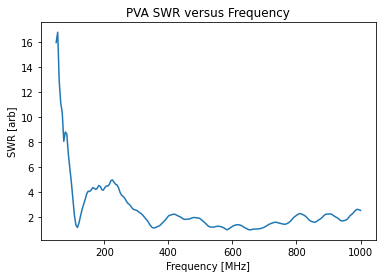

In [9]:
plt.plot(inputFreqSWR, swr)
plt.title("PVA SWR versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("SWR [arb]")

Text(0, 0.5, 'Reflection Coefficient [arb]')

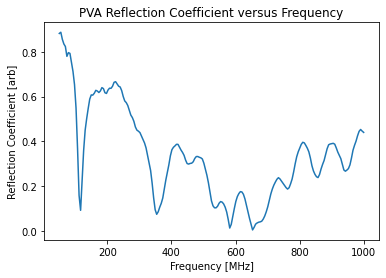

In [10]:
plt.plot(inputFreqSWR, reflectionCoefficient)
plt.title("PVA Reflection Coefficient versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Reflection Coefficient [arb]")

In [11]:
gainData[:,:].shape

(362, 21)

Text(0, 0.5, 'Re(Z) [Ohms]')

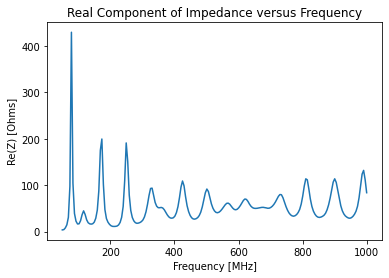

In [12]:
plt.plot(inputFreqImpedance, impedance.real)
plt.title("Real Component of Impedance versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Re(Z) [Ohms]")

Text(0, 0.5, 'Im(Z) [Ohms]')

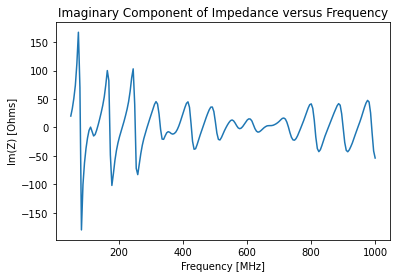

In [13]:
plt.plot(inputFreqImpedance, impedance.imag)
plt.title("Imaginary Component of Impedance versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Im(Z) [Ohms]")

Text(0, 0.5, 'Z [Ohms]')

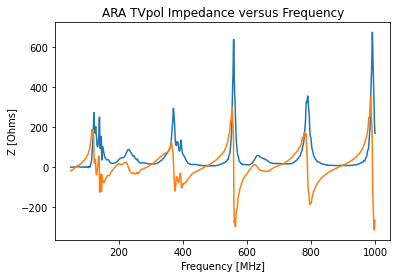

In [14]:
plt.plot(inputFreqAraImpedance, Z_TVpol.real)
plt.plot(inputFreqAraImpedance, Z_TVpol.imag)
plt.title("ARA TVpol Impedance versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Z [Ohms]")

Text(0, 0.5, 'Z [Ohms]')

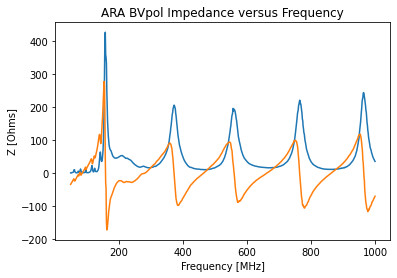

In [15]:
plt.plot(inputFreqAraImpedance, Z_BVpol.real)
plt.plot(inputFreqAraImpedance, Z_BVpol.imag)
plt.title("ARA BVpol Impedance versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Z [Ohms]")

Text(0, 0.5, 'Z [Ohms]')

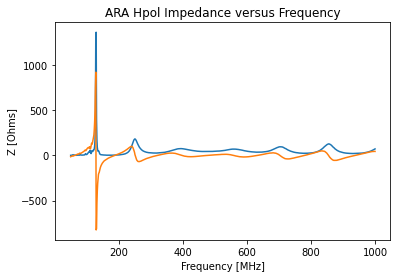

In [16]:
plt.plot(inputFreqAraImpedance, Z_Hpol.real)
plt.plot(inputFreqAraImpedance, Z_Hpol.imag)
plt.title("ARA Hpol Impedance versus Frequency")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Z [Ohms]")

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

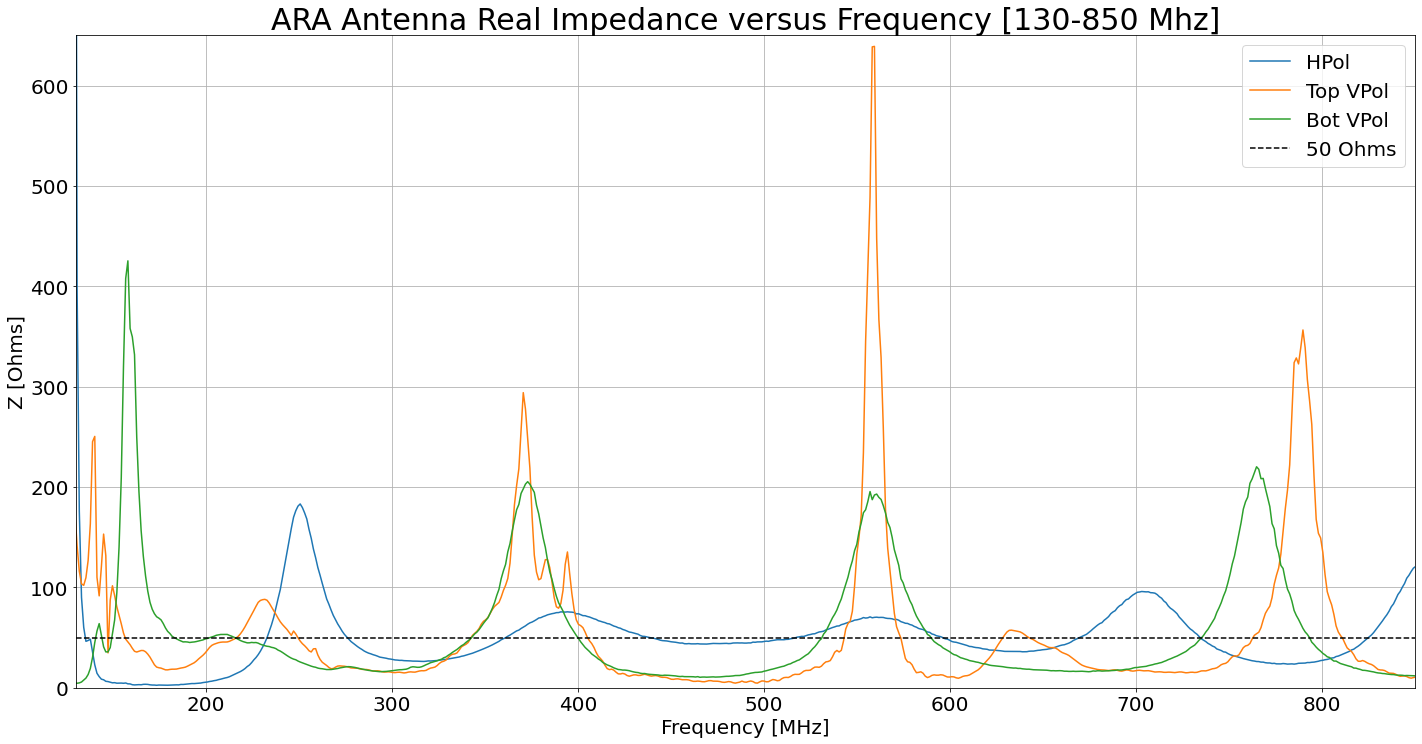

In [17]:
fig = plt.figure(figsize=(24,12))
titlefont=30
labelfont=20
plt.plot(inputFreqAraImpedance, Z_Hpol.real, label='HPol')
plt.plot(inputFreqAraImpedance, Z_TVpol.real, label='Top VPol')
plt.plot(inputFreqAraImpedance, Z_BVpol.real, label='Bot VPol')
plt.axhline(50, color='black', linestyle='--', label="50 Ohms")
plt.legend(fontsize=labelfont)
plt.title("ARA Antenna Real Impedance versus Frequency [130-850 Mhz]", fontsize=titlefont)
plt.xlabel("Frequency [MHz]", fontsize=labelfont)
plt.ylabel("Z [Ohms]", fontsize=labelfont)
plt.xlim([130,850])
plt.ylim([0,650])
plt.grid()
plt.xticks(fontsize=labelfont)
plt.yticks(fontsize=labelfont)

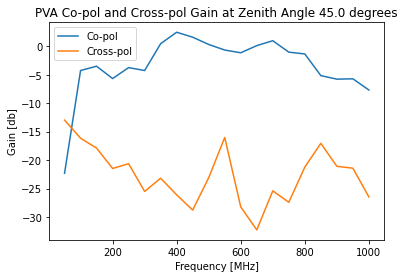

In [18]:
index = 45
plt.plot(inputFreq, pvaRealizedGainCopol[index,:], label="Co-pol")
plt.plot(inputFreq, pvaRealizedGainCrosspol[index,:], label="Cross-pol")
plt.title("PVA Co-pol and Cross-pol Gain at Zenith Angle " + str(inputZenith[index]) + " degrees")
plt.xlabel("Frequency [MHz]")
plt.ylabel("Gain [db]")
plt.legend()

In [19]:
#Create arrays for interpolation into the XF format
outputZenith = np.arange(0,185,5)
outputAzimuth = np.arange(0,360,5)
outputFreq = 1/6*np.arange(500,6500,100) #XF stores frequency in intervals of 100/6 for some reason.

In [20]:
# Check content and size of output arays
print("outputZenith array: ")
print(outputZenith)
print("\noutputZenith size: ")
print(outputZenith.size)

print("\noutputAzimuth array: ")
print(outputAzimuth)
print("\noutputAzimuth size: ")
print(outputAzimuth.size)

print("\noutputFreq array: ")
print(outputFreq)
print("\noutputFreq size: ")
print(outputFreq.size)

outputZenith array: 
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180]

outputZenith size: 
37

outputAzimuth array: 
[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175
 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265
 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355]

outputAzimuth size: 
72

outputFreq array: 
[  83.33333333  100.          116.66666667  133.33333333  150.
  166.66666667  183.33333333  200.          216.66666667  233.33333333
  250.          266.66666667  283.33333333  300.          316.66666667
  333.33333333  350.          366.66666667  383.33333333  400.
  416.66666667  433.33333333  450.          466.66666667  483.33333333
  500.          516.66666667  533.33333333  550.          566.66666667
  583.33333333  600.          61

In [21]:
# Check content (, shape) and size of input arrays
print("inputFreq array: ")
print(inputFreq)
print("\ninputFreq shape: ")
print(inputFreq.shape)
print("\ninputFreq size: ")
print(inputFreq.size)

print("\ngain array: ")
print(gain)
print("\ngain shape: ")
print(gain.shape)

inputFreq array: 
[  50  100  150  200  250  300  350  400  450  500  550  600  650  700
  750  800  850  900  950 1000]

inputFreq shape: 
(20,)

inputFreq size: 
20

gain array: 
[[-15.76283  -0.58158   1.64538 ... -12.36201  -9.24459  -7.52848]
 [-15.76353  -0.50518   1.65878 ... -14.33131  -9.00819  -9.24048]
 [-15.90473  -0.54848   1.60898 ... -13.35451  -9.06969  -7.03518]
 ...
 [-17.79473  -0.50588   1.65168 ... -11.75151  -9.40289  -7.80698]
 [-17.46473  -0.54708   1.71648 ... -14.48181  -8.49779  -7.68448]
 [-15.76283  -0.58158   1.64538 ... -12.36201  -9.24459  -7.52848]]

gain shape: 
(362, 20)


In [22]:
# Concatenate gain columns for interpolation
gain_flatten = gain.flatten()

# Check new gain "flattened"
print("\ngain_flatten shape: ")
print(gain_flatten.shape)
print("\ngain_flatten array: ")
print(gain_flatten)

print("\ngain_flatten elements corresponding to gain second column: ")
print(gain_flatten[20:40])
print("\ngain_flatten elements corresponding to gain second-to-last column: ")
print(gain_flatten[-40:-20])

print("\nOkay, fine. They match!")


gain_flatten shape: 
(7240,)

gain_flatten array: 
[-15.76283  -0.58158   1.64538 ... -12.36201  -9.24459  -7.52848]

gain_flatten elements corresponding to gain second column: 
[-15.76353  -0.50518   1.65878   0.55947  -0.59393  -2.44137  -3.2457
 -30.56568 -10.25321  -6.02393  -4.30675  -1.28357  -2.3555   -1.60325
  -3.45797  -7.60828 -11.15889 -14.33131  -9.00819  -9.24048]

gain_flatten elements corresponding to gain second-to-last column: 
[-17.46473  -0.54708   1.71648   0.47197  -0.28153  -3.08997  -3.2159
 -28.60878 -10.50401  -5.74383  -4.15515  -1.23457  -2.3151   -1.68945
  -3.50977  -7.20308 -12.39949 -14.48181  -8.49779  -7.68448]

Okay, fine. They match!


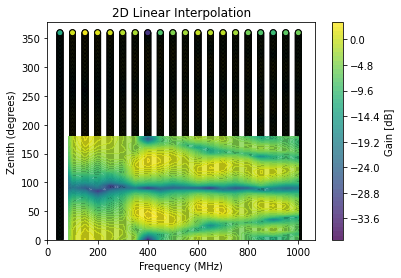

The black lines are dense regions of data points (hopefully). The colored region is the surface of interpolated gains. 


In [23]:
# Create a grid for interpolation
outputFreq, outputZenith = np.meshgrid(outputFreq, outputZenith)

# 2D linear interpolation
outputGain = griddata((np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq))), gain_flatten, (outputFreq, outputZenith), method='linear', fill_value=np.nan)

# Plot the original data points
plt.scatter(np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq)), c=gain_flatten, marker='o', edgecolors='k', cmap='viridis', label='Data Points')

# Plot the interpolated surface
plt.contourf(outputFreq, outputZenith, outputGain, cmap='viridis', alpha=0.8, levels=50)

# Add colorbar
plt.colorbar(label='Gain [dB]')

# Set labels and title
plt.xlabel('Frequency (MHz)')
plt.ylabel('Zenith (degrees)')
plt.title('2D Linear Interpolation')

# Show the plot
plt.show()

print("The black lines are dense regions of data points (hopefully). \
The colored region is the surface of interpolated gains. ")

In [26]:
# Check outputGain array

print("outputGain array: ")
print(outputGain)
print("\noutputGain shape: ")
print(outputGain.shape)
print("Good. 37 zenith angles and 60 frequencies!")
print("\noutputGain first column: ")
print(outputGain[0,:])

outputGain array: 
[[-5.64199667 -0.58158     0.16074    ...         nan         nan
          nan]
 [-5.64873    -0.53198     0.16917333 ...         nan         nan
          nan]
 [-5.75026333 -0.59308     0.08770667 ...         nan         nan
          nan]
 ...
 [-6.66033    -1.31058    -0.37849333 ...         nan         nan
          nan]
 [-6.51983    -1.10878    -0.16356    ...         nan         nan
          nan]
 [-6.29266333 -1.00008    -0.02472667 ...         nan         nan
          nan]]

outputGain shape: 
(37, 60)
Good. 37 zenith angles and 60 frequencies!

outputGain first column: 
[ -5.64199667  -0.58158      0.16074      0.90306      1.64538
   1.27074333   0.89610667   0.52147      0.12890333  -0.26366333
  -0.65623     -1.27824333  -1.90025667  -2.52227     -2.78721333
  -3.05215667  -3.3171     -14.65086    -25.98462    -37.31838
 -28.33412333 -19.34986667 -10.36561     -8.99351667  -7.62142333
  -6.24933     -5.44393667  -4.63854333  -3.83315     -3.02179
  -

In [27]:
# Get rid of stupid nans by using the last non-nan value
def replace_nan_with_last_non_nan(arr):
    result = arr.copy()
    for i in range(result.shape[0]):
        last_non_nan_value = np.nan
        for j in range(result.shape[1]):
            if not np.isnan(result[i, j]):
                last_non_nan_value = result[i, j]
            else:
                result[i, j] = last_non_nan_value
    return result

outputGain_nonnan=replace_nan_with_last_non_nan(outputGain)
print("outputGain_nonnan first column: ")
print(outputGain_nonnan[0,:])

print("\nI think that's how interpolation would be done \
in AraSim for frequencies out of data boundaries.")

outputGain_nonnan first column: 
[ -5.64199667  -0.58158      0.16074      0.90306      1.64538
   1.27074333   0.89610667   0.52147      0.12890333  -0.26366333
  -0.65623     -1.27824333  -1.90025667  -2.52227     -2.78721333
  -3.05215667  -3.3171     -14.65086    -25.98462    -37.31838
 -28.33412333 -19.34986667 -10.36561     -8.99351667  -7.62142333
  -6.24933     -5.44393667  -4.63854333  -3.83315     -3.02179
  -2.21043     -1.39907     -1.70048     -2.00189     -2.3033
  -2.19751667  -2.09173333  -1.98595     -2.59932333  -3.21269667
  -3.82607     -5.00924     -6.19241     -7.37558     -8.36741667
  -9.35925333 -10.35109    -11.02139667 -11.69170333 -12.36201
 -11.32287    -10.28373     -9.24459     -8.67255333  -8.10051667
  -7.52848     -7.52848     -7.52848     -7.52848     -7.52848   ]

I think that's how interpolation would be done in AraSim for frequencies out of data boundaries.


In [28]:
# Testing the interpolator
x1, y1, z1 = 0, 50, -15.76283
x2, y2, z2 = 0, 100, -0.58158

# Interpolation point
x, y = 0, 83.33

# Linear interpolation formula
z = z1 + ((z2 - z1) * (y - y1)) / (y2 - y1)

print(f"Interpolated z-value for (x, y) = ({x}, {y}): {z}")

print("This is what the gain at 83.33 MHz should be. \
It agrees with the first element of outputGain_nonnan. We could check more.")

Interpolated z-value for (x, y) = (0, 83.33): -5.64300875
This is what the gain at 83.33 MHz should be. It agrees with the first element of outputGain_nonnan. We could check more.


In [29]:
# Check phase aray

print("\nphase array: ")
print(phase)
print("\nphase shape: ")
print(phase.shape)


phase array: 
[[  92.0165  -56.9947  130.939  ...  -68.578  -127.997   141.135 ]
 [  94.1797  -56.5293  131.034  ...  -73.7589 -129.798   146.661 ]
 [  91.7863  -56.2767  131.493  ...  -58.877  -128.025   149.096 ]
 ...
 [  86.5403  -57.834   132.32   ...  -64.8847 -141.549   141.462 ]
 [  87.9645  -58.281   132.967  ...  -75.6353 -134.31    145.295 ]
 [  92.0165  -56.9947  130.939  ...  -68.578  -127.997   141.135 ]]

phase shape: 
(362, 20)


In [30]:
# Concatenate phase columns for interpolation
phase_flatten = phase.flatten()

# Check new gain "flattened"
print("\nphase_flatten shape: ")
print(phase_flatten.shape)
print("\nphase_flatten array: ")
print(phase_flatten)

print("\nphase_flatten elements corresponding to phase second column: ")
print(phase_flatten[20:40])
print("\nphase_flatten elements corresponding to phase second-to-last column: ")
print(phase_flatten[-40:-20])

print("\nOkay, fine. They match!")


phase_flatten shape: 
(7240,)

phase_flatten array: 
[  92.0165  -56.9947  130.939  ...  -68.578  -127.997   141.135 ]

phase_flatten elements corresponding to phase second column: 
[  94.1797   -56.5293   131.034     15.6348   -90.4288   170.595
   23.4633   -78.5486    -4.93988 -103.532    159.191     57.7425
  -38.6004  -131.238    127.4       26.3915   -35.6456   -73.7589
 -129.798    146.661  ]

phase_flatten elements corresponding to phase second-to-last column: 
[  87.9645  -58.281   132.967    15.6997  -90.1569  166.805    24.9652
  -24.443   -13.2472 -104.539   157.052    57.5257  -38.9852 -130.778
  124.799    25.0835  -45.5209  -75.6353 -134.31    145.295 ]

Okay, fine. They match!


In [31]:
# Concatenate cross pol columns for interpolation
crossPolGain_flatten = crossPolGain.flatten()

# Check new gain "flattened"
print("\nphase_flatten shape: ")
print(crossPolGain_flatten.shape)
print("\nphase_flatten array: ")
print(crossPolGain_flatten)

# print("\crossPol_flatten elements corresponding to crossPol second column: ")
# print(crossPol_flatten[20:40])
# print("\crossPol_flatten elements corresponding to crossPol second-to-last column: ")
# print(crossPol_flatten[-40:-20])

# print("\nOkay, fine. They match!")


phase_flatten shape: 
(7240,)

phase_flatten array: 
[-15.08313 -17.70008 -22.37012 ... -24.88541 -29.63689 -26.60268]


In [32]:
#Perform interpolation on SWR to include it in the output files.
interpSwr = sc.interpolate.interp1d(inputFreqSWR, swr)
interpSwr(50)

array(15.96852988)

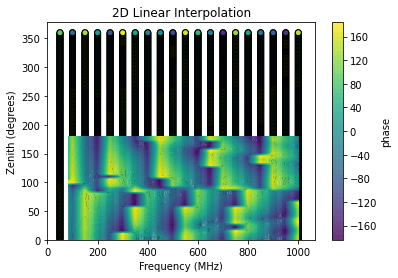

The black lines are dense regions of data points (hopefully). The colored region is the surface of interpolated gains. 


In [33]:
#Create new arrays for interpolation into the XF format
outputZenith_p = np.arange(0,185,5)
outputFreq_p = 1/6*np.arange(500,6500,100) #XF stores frequency in intervals of 100/6 for some reason.

# Create a grid for interpolation
outputFreq_p, outputZenith_p= np.meshgrid(outputFreq_p, outputZenith_p)

# 2D linear interpolation
outputPhase = griddata((np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq))), phase_flatten, (outputFreq_p, outputZenith_p), method='linear', fill_value=np.nan)

# Plot the original data points
plt.scatter(np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq)), c=phase_flatten, marker='o', edgecolors='k', cmap='viridis', label='Data Points')

# Plot the interpolated surface
plt.contourf(outputFreq_p, outputZenith_p, outputPhase, cmap='viridis', alpha=0.8, levels=50)

# Add colorbar
plt.colorbar(label='phase')

# Set labels and title
plt.xlabel('Frequency (MHz)')
plt.ylabel('Zenith (degrees)')
plt.title('2D Linear Interpolation')

# Show the plot
plt.show()

print("The black lines are dense regions of data points (hopefully). \
The colored region is the surface of interpolated gains. ")

In [34]:
# Check outputPhase array

print("outputPhase array: ")
print(outputPhase)
print("\noutputPhase shape: ")
print(outputPhase.shape)
print("Good. 37 zenith angles and 60 frequencies!")
print("\noutputPhase first column: ")
print(outputPhase[0,:])
print("\noutputPhase first column's last elements: ")
print(outputPhase[0,-5:-1])

outputPhase array: 
[[ -7.3243     -56.9947       5.64986667 ...          nan          nan
           nan]
 [ -5.76063333 -55.7442       7.1162     ...          nan          nan
           nan]
 [ -3.95183333 -54.7732       8.06286667 ...          nan          nan
           nan]
 ...
 [ 51.2891     125.905       69.57526667 ...          nan          nan
           nan]
 [ 51.43176667 123.444       67.23113333 ...          nan          nan
           nan]
 [ 49.214      121.457       65.59996667 ...          nan          nan
           nan]]

outputPhase shape: 
(37, 60)
Good. 37 zenith angles and 60 frequencies!

outputPhase first column: 
[  -7.3243      -56.9947        5.64986667   68.29443333  130.939
   92.49083333   54.04266667   15.5945      -19.786       -55.1665
  -90.547        -3.65966667   83.22766667  170.115       121.31753333
   72.52006667   23.7226        6.68483333  -10.35293333  -27.3907
  -20.71077667  -14.03085333   -7.35093     -40.09728667  -72.84364333
 -105.59 

In [35]:
outputPhase_nonnan=replace_nan_with_last_non_nan(outputPhase)
print("outputPhase_nonnan first column: ")
print(outputPhase_nonnan[0,:])

outputPhase_nonnan first column: 
[  -7.3243      -56.9947        5.64986667   68.29443333  130.939
   92.49083333   54.04266667   15.5945      -19.786       -55.1665
  -90.547        -3.65966667   83.22766667  170.115       121.31753333
   72.52006667   23.7226        6.68483333  -10.35293333  -27.3907
  -20.71077667  -14.03085333   -7.35093     -40.09728667  -72.84364333
 -105.59        -17.57466667   70.44066667  158.456       124.4079
   90.3598       56.3117       25.58533333   -5.14103333  -35.8674
  -67.75926667  -99.65113333 -131.543       -46.171        39.201
  124.573        91.13066667   57.68833333   24.246         1.06186667
  -22.12226667  -45.3064      -53.0636      -60.8208      -68.578
  -88.38433333 -108.19066667 -127.997       -38.28633333   51.42433333
  141.135       141.135       141.135       141.135       141.135     ]


In [36]:

# Testing the interpolator
x1, y1, z1 = 0, 50,  92.0165  
x2, y2, z2 = 0, 100, -56.9947

# Interpolation point
x, y = 0, 83.33

# Linear interpolation formula
z = z1 + ((z2 - z1) * (y - y1)) / (y2 - y1)

print(f"Interpolated z-value for (x, y) = ({x}, {y}): {z}")

print("This is what the phase at 83.33 MHz should be. \
It agrees with the first element of outputPhase_nonnan. We could check more.")

Interpolated z-value for (x, y) = (0, 83.33): -7.31436592
This is what the phase at 83.33 MHz should be. It agrees with the first element of outputPhase_nonnan. We could check more.


In [37]:
X = [83.33, 100]  # Add more values as needed
Y_1 = list(range(0, 181, 5))
Y_2 = np.array((range(0, 356, 5)))
Z_1 = np.array([[-80.83, -21.10, -15.10, -11.62, -9.19, -7.34, -5.86, -4.65, -3.64, -2.79, -2.08,
     -1.48, -0.98, -0.57, -0.25, 0.00, 0.18, 0.29, 0.32, 0.29, 0.18, 0.01, -0.25, -0.57,
     -0.98, -1.48, -2.08, -2.79, -3.64, -4.65, -5.86, -7.33, -9.19, -11.62, -15.09, -21.08, -80.83],[-86.83, -20.63, -14.64, -11.15, 
    -8.71, -6.85, -5.36, -4.14, -3.12, -2.26, -1.54, -0.93, -0.42, 0.00, 0.34, 0.59, 0.78, 0.89, 0.92, 0.89, 0.78, 0.59, 0.34, 0.00, -0.42, -0.93, -1.54, 
    -2.26, -3.12, -4.14, -5.36, -6.85, -8.71, -11.15, -14.63, -20.63, -86.83]])
Z_2 = np.array([[-0.41, 168.18, 168.17, 168.14, 168.09, 168.04, 167.97, 167.91, 167.83, 167.76,
                        167.70, 167.64, 167.59, 167.55, 167.53, 167.51, 167.50, 167.50, 167.50, 167.50,
                        167.50, 167.51, 167.53, 167.55, 167.59, 167.64, 167.70, 167.77, 167.84, 167.91,
                        167.98, 168.04, 168.10, 168.15, 168.18, 168.21, 179.59], [-0.65, 149.18, 149.16, 149.12, 149.07, 149.00, 148.92, 148.84, 148.76, 
                        148.68, 148.61, 148.55, 148.50, 148.45, 148.42, 148.39, 148.36, 148.35, 148.34, 148.35, 148.36, 148.39, 148.42, 148.45, 148.50, 
                        148.55, 148.61, 148.68, 148.76, 148.84, 148.92, 149.00, 149.07, 149.13, 149.17, 149.21, 179.35]])


#print(Z_1.shape[0])
#print(Y_2)

# Writing data to a file
file_path = 'ReconstructinDipoleGain.txt'

with open(file_path, 'w') as file:
    freq_count = 0
    # Writing header
    for x in X:
        file.write("freq : {:.2f} MHz\n".format(x))
        file.write("SWR : 1\n")
        file.write(" Theta   Phi \t Gain(dB)   \t   Gain   \t   Phase(deg)\n")

        for y_2 in Y_2:
            # Writing data
            for y_1, z_1, z_2 in zip(Y_1, Z_1[freq_count], Z_2[freq_count]):
                z_1_notdB = 10**(z_1/10) 
                file.write("{:3d} \t {:3d} \t {:7.2f}     \t   {:12.2f}     \t    {:14.2f}\n".format(y_1, y_2, z_1, z_1_notdB, z_2))
        freq_count +=1

print("File has been created at:", file_path)

File has been created at: ReconstructinDipoleGain.txt


In [38]:
#Create arrays for interpolation into the XF format
outputZenith = np.arange(0,185,5)
outputAzimuth = np.arange(0,360,5)
# outputFreq = 1/6*np.arange(500,6500,100) #XF stores frequency in intervals of 100/6 for some reason.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'PVA_MohammadData_2023.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        file.write("freq : {:.2f} MHz\n".format(freq))
        # file.write("SWR : 1\n") 
        file.write("SWR : {:.2f}\n".format(interpSwr(freq))) #Changing this to use the interpolated SWR added above. - JCF 12/13/2023
        file.write(" Theta   Phi \t Gain(dB)   \t   Gain   \t   Phase(deg)\n")

        for azimuth in outputAzimuth:
            #print(azimuth)
            #print(outputAzimuth)
            # Writing data
        #print(outputGain_nonnan[freq_count])
            for zenith, gaindB, phase in zip(outputZenith, outputGain_nonnan[:,freq_count], outputPhase_nonnan[:,freq_count]):
                #print(zenith)
                #print(outputZenith[:,0])
                #print(gaindB)
                #print(outputGain_nonnan[freq_count])
                gain_notdB = 10**(gaindB/10)
                #print(gain_notdB)
                #print(phase)
                #print(outputPhase_nonnan[freq_count])
                file.write("{:3d} {:3d} {:7.2f} {:12.2f} {:14.2f}\n".format(zenith, azimuth, gaindB, gain_notdB, phase))
                # file.write("{:d}\t {:d}\t {:.2f}\t\t\t   {:.2f}\t\t\t    {:.2f}\n".format(zenith, azimuth, gaindB, gain_notdB, phase))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: PVA_MohammadData_2023.txt


In [147]:
#Create arrays for interpolation into the XF format
outputZenith = np.arange(0,185,5)
outputAzimuth = np.arange(0,360,5)
# outputFreq = 1/6*np.arange(500,6500,100) #XF stores frequency in intervals of 100/6 for some reason.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'PVA_CrossPol_MohammadData_2023.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        file.write("freq : {:.2f} MHz\n".format(freq))
        # file.write("SWR : 1\n") 
        file.write("SWR : {:.2f}\n".format(interpSwr(freq))) #Changing this to use the interpolated SWR added above. - JCF 12/13/2023
        file.write(" Theta   Phi \t Gain(dB)   \t   Gain   \t   Phase(deg)\n")

        for azimuth in outputAzimuth:
            #print(azimuth)
            #print(outputAzimuth)
            # Writing data
        #print(outputGain_nonnan[freq_count])
            for zenith, gaindB, phase in zip(outputZenith, outputGain_nonnan[:,freq_count], outputPhase_nonnan[:,freq_count]):
                #print(zenith)
                #print(outputZenith[:,0])
                #print(gaindB)
                #print(outputGain_nonnan[freq_count])
                gain_notdB = 10**(gaindB/10)
                #print(gain_notdB)
                #print(phase)
                #print(outputPhase_nonnan[freq_count])
                file.write("{:3d} {:3d} {:7.2f} {:12.2f} {:14.2f}\n".format(zenith, azimuth, gaindB, gain_notdB, phase))
                # file.write("{:d}\t {:d}\t {:.2f}\t\t\t   {:.2f}\t\t\t    {:.2f}\n".format(zenith, azimuth, gaindB, gain_notdB, phase))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: PVA_CrossPol_MohammadData_2023.txt


In [148]:
# #Apply Alan's interpolation to the cross pol.
# #Create new arrays for interpolation into the XF format
# outputZenith_p = np.arange(0,185,5)
# outputFreq_p = 1/6*np.arange(500,6500,100) #XF stores frequency in intervals of 100/6 for some reason.

# # Create a grid for interpolation
# outputFreq_p, outputZenith_p= np.meshgrid(outputFreq_p, outputZenith_p)

# # 2D linear interpolation
# outputPhase = griddata((np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq))), phase_flatten, (outputFreq_p, outputZenith_p), method='linear', fill_value=np.nan)

# # Plot the original data points
# plt.scatter(np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq)), c=phase_flatten, marker='o', edgecolors='k', cmap='viridis', label='Data Points')

# # Plot the interpolated surface
# plt.contourf(outputFreq_p, outputZenith_p, outputPhase, cmap='viridis', alpha=0.8, levels=50)

# # Add colorbar
# plt.colorbar(label='phase')

# # Set labels and title
# plt.xlabel('Frequency (MHz)')
# plt.ylabel('Zenith (degrees)')
# plt.title('2D Linear Interpolation')

# # Show the plot
# plt.show()

In [149]:
#Apply Alan's interpolation to S11 and the Impedance

#Create interpolations for real and complex components of impedance
interpImpedanceReal = sc.interpolate.interp1d(inputFreqImpedance, impedance.real)
interpImpedanceImag = sc.interpolate.interp1d(inputFreqImpedance, impedance.imag)

#Actually I need to check what the best file format would be for this.  Should keep same frequency intervals as XF files though.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'PVA_Impedance_2023.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    file.write("Freq (MHz) \t Real[Z] (Ohm) \t Imag[Z] (Ohm)\n")
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        

        file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, interpImpedanceReal(freq), interpImpedanceImag(freq)))
        # file.write("{:7f} \t {:12.2f} \t {:14.2f}\n".format(freq, interpImpedanceReal(freq), interpImpedanceImag(freq)))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: PVA_Impedance_2023.txt


In [150]:
#Create a dummy impedance file for the simple ARA approximation of Real(Z) = 50 Ohms

#Create interpolations for real and complex components of impedance
interpImpedanceReal = sc.interpolate.interp1d(inputFreqImpedance, impedance.real)
interpImpedanceImag = sc.interpolate.interp1d(inputFreqImpedance, impedance.imag)

#Actually I need to check what the best file format would be for this.  Should keep same frequency intervals as XF files though.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'ARA_Impedance_SimpleApproximation.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    file.write("Freq (MHz) \t Real[Z] (Ohm) \t Imag[Z] (Ohm)\n")
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        

        file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, 50, 0))
        # file.write("{:7f} \t {:12.2f} \t {:14.2f}\n".format(freq, interpImpedanceReal(freq), interpImpedanceImag(freq)))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: ARA_Impedance_SimpleApproximation.txt


In [151]:
#Create interpolation for ARA TVpol

#Create interpolations for real and complex components of impedance
interpImpedanceReal = sc.interpolate.interp1d(inputFreqAraImpedance, Z_TVpol.real)
interpImpedanceImag = sc.interpolate.interp1d(inputFreqAraImpedance, Z_TVpol.imag)

#Actually I need to check what the best file format would be for this.  Should keep same frequency intervals as XF files though.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'ARA_TVpol_MohammadData_2024.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    file.write("Freq (MHz) \t Real[Z] (Ohm) \t Imag[Z] (Ohm)\n")
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        

        # file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, 50, 0))
        file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, interpImpedanceReal(freq), interpImpedanceImag(freq)))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: ARA_TVpol_MohammadData_2024.txt


In [152]:
#Create interpolation for ARA BVpol

#Create interpolations for real and complex components of impedance
interpImpedanceReal = sc.interpolate.interp1d(inputFreqAraImpedance, Z_BVpol.real)
interpImpedanceImag = sc.interpolate.interp1d(inputFreqAraImpedance, Z_BVpol.imag)

#Actually I need to check what the best file format would be for this.  Should keep same frequency intervals as XF files though.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'ARA_BVpol_MohammadData_2024.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    file.write("Freq (MHz) \t Real[Z] (Ohm) \t Imag[Z] (Ohm)\n")
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        

        # file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, 50, 0))
        file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, interpImpedanceReal(freq), interpImpedanceImag(freq)))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: ARA_BVpol_MohammadData_2024.txt


In [153]:
#Create interpolation for ARA Hpol

#Create interpolations for real and complex components of impedance
interpImpedanceReal = sc.interpolate.interp1d(inputFreqAraImpedance, Z_Hpol.real)
interpImpedanceImag = sc.interpolate.interp1d(inputFreqAraImpedance, Z_Hpol.imag)

#Actually I need to check what the best file format would be for this.  Should keep same frequency intervals as XF files though.
outputFreq = 1/6*np.arange(500,6100,100) #Changing to go only to 1000 MHz as that's the extent of my data.

# Writing data to a file
# file_path_new = 'pvaGainPhase2023.txt'
file_path_new = 'ARA_Hpol_MohammadData_2024.txt'

#print(outputGain_nonnan.shape)

with open(file_path_new, 'w') as file:
    freq_count = 0
    # Writing header
    file.write("Freq (MHz) \t Real[Z] (Ohm) \t Imag[Z] (Ohm)\n")
    for freq in outputFreq:
        #print(freq)
        #print(outputFreq)
        #print(outputFreq.size)
        

        # file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, 50, 0))
        file.write("{:7.2f} \t {:12.2f} \t {:14.2f}\n".format(freq, interpImpedanceReal(freq), interpImpedanceImag(freq)))
        freq_count +=1

print("File has been created at:", file_path_new)

File has been created at: ARA_Hpol_MohammadData_2024.txt


In [154]:
#Calculate swr for ARA Vpol and Hpol from impedance.  Then interpolate the gain and phase into XF-ified files.

# VSWR = (1 + |S11|) / (1 - |S11|)
# S11(f) = (Z_A(f) - Z_L) / (Z_A(f) + Z_L)

def s11FromImpedance(Z_A, Z_L=50):
    return (Z_A-Z_L)/(Z_A+Z_L)

def vswrFromS11(s11):
    return (1 + np.abs(s11))/(1 - np.abs(s11))

def vswrFromImpedance(Z_A,Z_L=50):
    return vswrFromS11(s11FromImpedance(Z_A,Z_L))

swr_TVpol = vswrFromImpedance(Z_TVpol)
swr_BVpol = vswrFromImpedance(Z_BVpol)
swr_Hpol = vswrFromImpedance(Z_Hpol)
swr_PVA = swr

In [42]:
def interpolateToXF(inputFreq, inputZenith, inputGain, inputPhase, inputSwr, freqForSwr=None, outFile="test.txt"):
    #Debugging to print sizes
    # print("inputFreq.shape = " + str(inputFreq.shape))
    # print("inputZenith.shape = " + str(inputZenith.shape))
    # print("inputGain.shape = " + str(inputGain.shape))
    # print("inputPhase.shape = " + str(inputPhase.shape))
    # print("inputSwr.shape = " + str(inputSwr.shape))
    # if (freqForSwr is not None):
    #     print("freqForSwr.shape = " + str(freqForSwr.shape))
    
    
    #Initialize output zenith, azimuth and frequency
    outputZenith = np.arange(0,185,5)
    outputAzimuth = np.arange(0,360,5)
    outputFreq = 1/6*np.arange(500,6100,100)
    
    # Create a grid for interpolation
    outputFreqMesh, outputZenithMesh = np.meshgrid(outputFreq, outputZenith)

    # 2D linear interpolation
    outputGain = griddata((np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq))), inputGain.flatten(), (outputFreqMesh, outputZenithMesh), method='linear', fill_value=np.nan)
    outputPhase = griddata((np.tile(inputFreq, len(inputZenith)), np.repeat(inputZenith, len(inputFreq))), inputPhase.flatten(), (outputFreqMesh, outputZenithMesh), method='linear', fill_value=np.nan)
    
    #Replaces nan's
    outputGain_nonnan=replace_nan_with_last_non_nan(outputGain)
    outputPhase_nonnan=replace_nan_with_last_non_nan(outputPhase)   
    
    #Interpolate swr
    if (freqForSwr is not None):
        interpSwr = sc.interpolate.interp1d(freqForSwr, inputSwr)
    else:
        interpSwr = sc.interpolate.interp1d(inputFreq, inputSwr)

    with open(outFile, 'w') as file:
        freq_count = 0
        # Writing header
        for freq in outputFreq:
            # print(freq)
            # print(outputFreq)
            # print(outputFreq.shape)
            file.write("freq : {:.2f} MHz\n".format(freq))
            # file.write("SWR : 1\n") 
            file.write("SWR : {:.2f}\n".format(interpSwr(freq))) #Changing this to use the interpolated SWR added above. - JCF 12/13/2023
            file.write(" Theta   Phi \t Gain(dB)   \t   Gain   \t   Phase(deg)\n")
    
            for azimuth in outputAzimuth:
                #print(azimuth)
                #print(outputAzimuth)
                # Writing data
            #print(outputGain_nonnan[freq_count])
                for zenith, gaindB, phase in zip(outputZenith, outputGain_nonnan[:,freq_count], outputPhase_nonnan[:,freq_count]):
                    #print(zenith)
                    #print(outputZenith[:,0])
                    #print(gaindB)
                    #print(outputGain_nonnan[freq_count])
                    gain_notdB = 10**(gaindB/10)
                    #print(gain_notdB)
                    #print(phase)
                    #print(outputPhase_nonnan[freq_count])
                    file.write("{:3d} {:3d} {:7.2f} {:12.2f} {:14.2f}\n".format(zenith, azimuth, gaindB, gain_notdB, phase))
                    # file.write("{:d}\t {:d}\t {:.2f}\t\t\t   {:.2f}\t\t\t    {:.2f}\n".format(zenith, azimuth, gaindB, gain_notdB, phase))
            freq_count +=1
    
    print("File has been created at:", outFile)        

In [43]:
interpolateToXF(inputFreqRealized, inputZenithRealized, pvaRealizedGainCopol, pvaRealizedPhaseCopol, swr, freqForSwr=inputFreqSWR, outFile="test.txt")

inputFreq.shape = (20,)
inputZenith.shape = (180,)
inputGain.shape = (180, 20)
inputPhase.shape = (180, 20)
inputSwr.shape = (201,)
freqForSwr.shape = (201,)
(37,)
(72,)
(56,)
(37,)
(72,)
(56,)
File has been created at: test.txt
